# NCI60 using Clest

In [1]:
library("ISLR") 
library("RSKC")
library("dplyr")
library("caret")
library("MLmetrics")
library("ggplot2")
library("ggrepel")
library("reshape2")

options(scipen=10)
options(repr.plot.width=12, repr.plot.height=12)

Cargando paquete requerido: flexclust

Cargando paquete requerido: grid

Cargando paquete requerido: lattice

Cargando paquete requerido: modeltools

Cargando paquete requerido: stats4


Adjuntando el paquete: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Cargando paquete requerido: ggplot2


Adjuntando el paquete: 'MLmetrics'


The following objects are masked from 'package:caret':

    MAE, RMSE


The following object is masked from 'package:RSKC':

    Sensitivity


The following object is masked from 'package:base':

    Recall




In [2]:
getRversion()
packageVersion("RSKC")

[1] '4.4.1'

[1] '2.4.2'

# Table of contents
* [Dataset](#dataset)
    * [Top 200](#top)
* [Cest](#clest)
    * [RSKC](#rskc)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
nci60 = as.data.frame(NCI60$data)
head(nci60)

,1,2,3,4,5,6,7,8,9,10,⋯,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V1,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.45000000,-0.65498050,⋯,-0.9900195,0.000000,0.030000,-0.175000,0.6299805,-0.030000,0.0000000,0.280000,-0.340000,-1.930000
V2,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.04003899,-0.28501950,⋯,-0.2700585,-0.300039,-0.250039,-0.535039,0.1099415,-0.860039,-1.2500490,-0.770039,-0.390039,-2.000039
V3,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.43000000,0.47501950,⋯,0.3199805,0.120000,-0.740000,-0.595000,-0.2700195,-0.150000,0.0000000,-0.120000,-0.410000,0.000000
V4,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.02000000,0.09501949,⋯,-1.2400200,-0.110000,-0.160000,0.095000,-0.3500195,-0.300000,-1.1500100,1.090000,-0.260000,-1.100000
V5,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.23500000,1.49001949,⋯,0.5549805,-0.775000,-0.515000,-0.320000,0.6349805,0.605000,0.0000000,0.745000,0.425000,0.145000
V6,0.310000,-0.030000,-0.100000,-0.460000,-0.205000,-5.400000e-01,-0.640000,-0.585000,-0.77000000,-0.24498050,⋯,-0.5900195,0.000000,-0.740000,-2.095000,-1.3900200,-0.400000,0.6999902,0.290000,0.550000,0.000000


There are 14 types of classes within the dataset: **CNS**, **RENAL**, **BREAST**, **NSCLC**, **UNKNOWN**, **OVARIAN**, **MELANOMA**, **PROSTATE**, **LEUKEMIA**, **K562B-repro**, **K562A-repro**, **COLON**, **MCF7A-repro** and **MCF7D-repro**:

In [4]:
as.vector(unlist(unique(NCI60$labs)))

[1] "CNS"         "RENAL"       "BREAST"      "NSCLC"       "UNKNOWN"    
 [6] "OVARIAN"     "MELANOMA"    "PROSTATE"    "LEUKEMIA"    "K562B-repro"
[11] "K562A-repro" "COLON"       "MCF7A-repro" "MCF7D-repro"

Here, we prepare the NCI60 dataset for the analysis:

- We add a column named `Description` containing the class (category) of each row
- Due to their small class size, we remove the two prostate cell lines and the unknown cell line, "PROSTATE" and "UNKNOWN" entires respectively.

In [5]:
nci60["labels"] = rownames(nci60)
nci60 = nci60[ , c("labels", names(nci60)[names(nci60) != "labels"])]
nci60["labels"] = NCI60$labs
colnames(nci60)[colnames(nci60) == 'labels'] <- 'Description'
nci60 = nci60[!grepl("UNKNOWN", nci60$Description),] # Remove UNKNOWN
nci60 = nci60[!grepl("PROSTATE", nci60$Description),] # Remove PROSTATE

## Top 200 <a class="anchor" id="top"></a>

We now filter the metrics for including only the top 200 with the greatest variance, as these metrics have the most significant impact on clustering.

In [6]:
variance = sort(sapply(nci60[-1], var), decreasing = TRUE)  # Sorted gene variance
nci60_var = as.data.frame(variance)
nci60_var["Description"] = rownames(nci60_var)

In [7]:
top_number = 200
top_rows = nci60_var[c(1:top_number), ]
head(top_rows)

,variance,Description
,<dbl>,<chr>
4701,11.942075,4701
4700,11.429800,4700
256,7.978482,256
16,7.715338,16
4699,7.711871,4699
6393,7.659845,6393


In [8]:
row_list = as.list(top_rows["Description"])
top_row_list = unlist(setdiff(row_list, names(nci60)))
top_nci60 = nci60[, top_row_list]
top_nci60["Description"] = nci60[rownames(top_nci60) %in% rownames(nci60), "Description"]
top_nci60 = top_nci60[ , c("Description", names(top_nci60)[names(top_nci60) != "Description"])] 

The dataframe `top_nci60` contains 200 genes (metrics) which provides the most variance.

In [9]:
head(top_nci60)

,Description,4701,4700,256,16,4699,6393,6149,286,6415,⋯,5721,6622,5336,1067,6288,5872,5489,78,127,3383
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V1,CNS,5.770000,5.820000,-1.910000,-2.37,4.760000,5.4799900,0.000000,0.610000,5.230000,⋯,2.790000,1.210000,-0.890000,-1.055010,-2.1850100,0.045000,1.990000,2.360000,-1.305000,-0.5400195
V2,CNS,5.039961,5.069961,-1.980039,0.00,4.779961,5.7299510,-0.480039,-3.980039,5.329961,⋯,1.629961,1.599961,-1.060039,-1.055049,-3.4050490,0.874961,2.609961,0.869961,-0.375039,0.4799415
V3,CNS,-1.440000,-1.030000,-0.580000,0.00,0.000000,4.6299900,2.060000,-1.580000,0.000000,⋯,1.920000,-0.260000,0.000000,1.294990,-0.6850098,1.445000,0.200000,1.990000,0.705000,0.3199805
V4,RENAL,-2.420000,-2.420000,-1.880000,-1.02,-2.590000,1.2999900,5.190000,-4.880000,7.020000,⋯,3.200000,1.110000,1.060000,1.414990,-4.4750100,2.365000,1.080000,3.600000,-0.685000,0.1399805
V5,BREAST,-2.955000,-2.955000,-1.235000,0.00,-2.535000,-1.0550098,7.425000,-3.235000,4.395000,⋯,2.865000,1.245000,0.000000,-1.480010,-3.8300098,3.320000,-1.155000,-1.385000,-1.220000,0.4449805
V6,CNS,0.000000,-3.180000,-3.050000,-0.05,-1.170000,0.5899902,4.230000,-5.050000,-0.220000,⋯,2.860000,1.360000,0.000000,-1.425010,-2.2550100,1.615000,-0.970000,1.370000,-2.445000,-1.5400200


# Clest <a class="anchor" id="clest"></a>
Execution of Clest over the previous dataset.

In [10]:
set.seed(13606)
nstart = 1000
#L1 = 6
L1 = 11.2112753007614
alpha = 0.1
top_nci60_matrix = as.matrix(top_nci60[, -1])
clest_result = Clest(top_nci60_matrix, maxK=10, alpha=alpha, B = 15, B0 = 5, nstart = nstart, L1 = L1, beta = 0.1, pca = FALSE, silent=TRUE)
print(paste0("Best k is: ", clest_result$K))

RSKC will be performed (maxK-1)*(B0*1*(1+1)+B*(1+1))= 360 times

Assessing the observed data 
[1] "Best k is: 6"


In [11]:
clest_result$result.table = clest_result$result.table[-1, ]
names(clest_result)
clest_result$result.table

[1] "call"          "K"             "result.table"  "referenceCERs"
[5] "observedCERs"

,test.stat,obsCER,refCER,P-value
3,-0.2442105,0.2052632,0.4494737,0
4,-0.2242105,0.2000000,0.4242105,0
5,-0.2221053,0.1157895,0.3378947,0
6,-0.3157895,0.1368421,0.4526316,0
7,-0.2263158,0.1368421,0.3631579,0
8,-0.2484211,0.1210526,0.3694737,0
9,-0.1094737,0.1157895,0.2252632,0
10,-0.1442105,0.1105263,0.2547368,0


In [12]:
clest_result$result.table = as.data.frame(clest_result$result.table)
clest_result$result.table$k = as.numeric(rownames(clest_result$result.table))

In [13]:
melted_data <- melt(clest_result$result.table, id.vars = 'k', measure.vars = c('obsCER', 'refCER'))
head(melted_data)

,k,variable,value
,<dbl>,<fct>,<dbl>
1,3,obsCER,0.2052632
2,4,obsCER,0.2000000
3,5,obsCER,0.1157895
4,6,obsCER,0.1368421
5,7,obsCER,0.1368421
6,8,obsCER,0.1210526


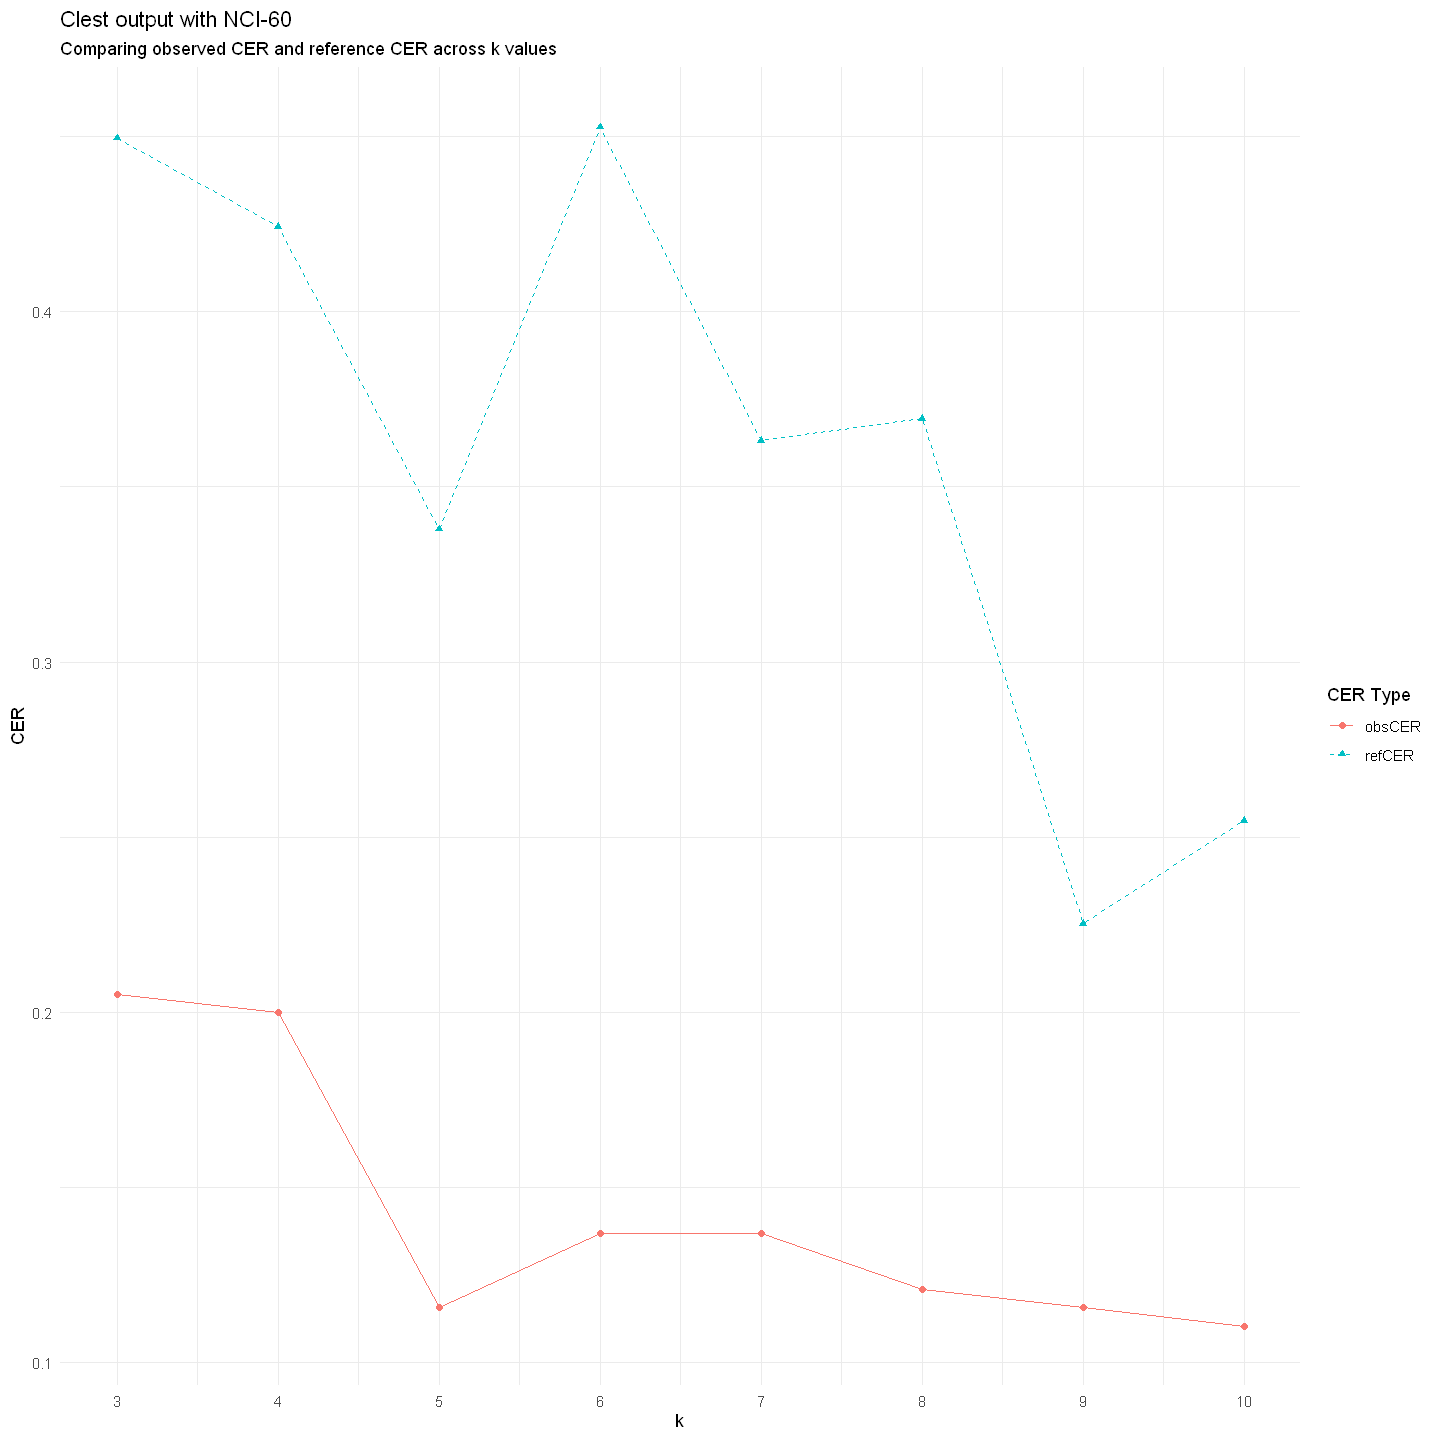

In [14]:
ggplot(melted_data, aes(x = k, y = value, color = variable, linetype = variable, shape = variable)) +
  geom_point() +
  geom_line() +
  scale_linetype_manual(values = c("solid", "dashed")) +
  scale_shape_manual(values = c(16, 17)) +
  scale_x_continuous(breaks = melted_data$k) +
  labs(title = "Clest output with NCI-60",
       subtitle = "Comparing observed CER and reference CER across k values",
       x = "k",
       y = "CER",
       linetype = "CER Type",
       shape = "CER Type",
       color = "CER Type") +
  theme_minimal()

## RSKC <a class="anchor" id="rskc"></a>
Running RSKC with the same parameters as Clest to retrieve the individuals per cluster.

In [15]:
rT<-RSKC(top_nci60_matrix, ncl = clest_result$K, alpha = alpha, L1 = L1, nstart = nstart, silent = TRUE)

In [16]:
labels = rT$labels

In [17]:
trimmedRows = c()
if (length(rT$oW) > 1) {
    trimmedRows  = c(rT$oE,rT$oW)
    trimmedRows = unique(trimmedRows)
    trimmedRows = sort(trimmedRows)
    message(paste0("\tNumber of trimmed cases: ", length(trimmedRows)))
    top_nci60 = top_nci60[-trimmedRows, ]
    labels = labels[-trimmedRows]
}


	Number of trimmed cases: 7



In [18]:
trimmedColumns = names(rT$weights)[rT$weights == 0]
if (length(trimmedColumns) > 0) {
    message(paste0("\tNumber of affected columns: ", length(trimmedColumns)))
    top_nci60 = top_nci60[, !(names(top_nci60) %in% trimmedColumns)]
}

	Number of affected columns: 3



# PCA <a class="anchor" id="pca"></a>
We employ Principal Component Analysis (PCA) as a dimensionality reduction technique to facilitate the visualization of clusters within our dataset. PCA allow us to transform the original high-dimensional data into a lower-dimensional space, while preserving as much of the variability as possible.

In [19]:
top_nci60["inCluster"] = as.numeric(labels)
pca_matrix = top_nci60 %>% select(-Description, -inCluster)
pca_result <- prcomp(pca_matrix, scale. = TRUE)
pca_df <- data.frame(pca_result$x)
pca_df$Cluster <- as.factor(top_nci60$inCluster)
pca_df$Individual <- top_nci60$Description
head(pca_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,Cluster,Individual
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
V1,-6.254786,0.1282094,-2.431944,5.880122,-4.7991485,4.4730400,-0.0157922,3.556741,-0.8977973,2.6609919,⋯,-1.953721848,0.3243438,0.40924312,0.48025089,-0.2400962,-0.698876031,1.21901714,3.616164e-15,1,CNS
V2,-6.175318,-1.2035723,-3.044739,4.951965,-5.3622008,5.6565282,-0.1852564,4.144812,-2.3097717,2.8630531,⋯,1.745653013,-0.2572544,-0.31207393,-0.42760750,0.2612200,0.735387137,-1.19392397,2.151292e-15,1,CNS
V3,-8.301388,0.5930776,-2.761450,1.473972,-5.0674298,1.7824641,-3.5267022,-1.667932,-0.8980462,-1.4620790,⋯,0.368067289,-0.4142046,-0.03311634,0.14853766,-0.1074674,0.437399975,-0.51027172,1.751663e-15,4,CNS
V6,-8.435289,-1.8641133,-3.696029,4.003211,-1.6958788,-2.9061924,-3.6694011,-6.412844,-2.9171235,-4.8181796,⋯,0.126036280,-0.3772265,-0.15507886,0.02521459,0.0558637,-0.110774431,0.04686477,4.141576e-16,4,CNS
V7,-8.957647,-1.2889206,-5.382846,5.296414,1.4963175,-0.5690616,-2.4060370,-1.425974,-0.5685393,2.3953956,⋯,0.001676569,0.5564921,0.01948530,-0.37147785,-0.1642024,-0.391015976,0.38308715,7.588532e-16,4,CNS
V8,-6.813825,-1.5384759,-3.422179,3.949022,-0.6265393,-0.9964866,-3.5568087,-2.301324,-3.0355438,-0.0814719,⋯,-0.076385124,0.6085448,-0.13394501,0.10129177,-0.1289236,0.009550845,0.08098111,1.175814e-15,4,BREAST


Warning message:
"The following aesthetics were dropped during statistical transformation: label.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"


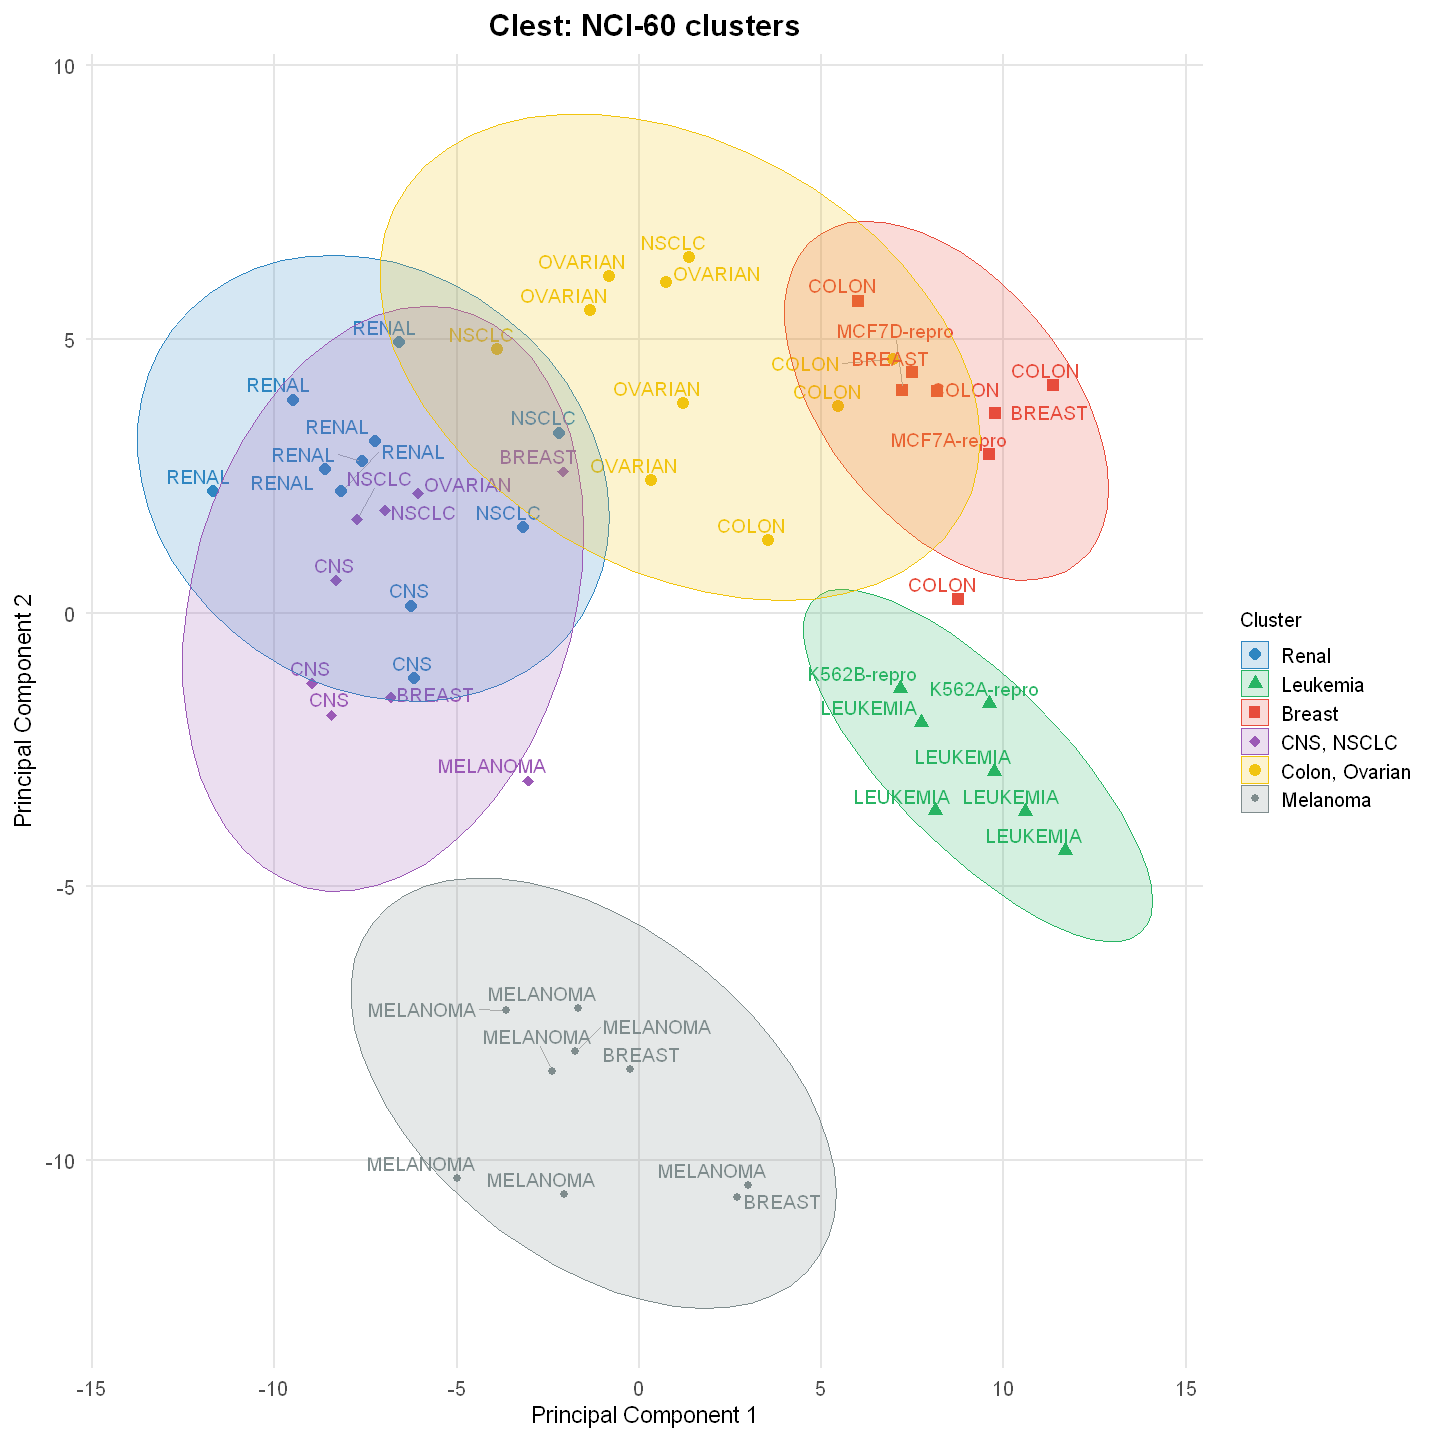

In [20]:
custom_colors <- c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#F1C40F", "#7F8C8D")

cluster_shapes <- c(16, 17, 15, 18, 19, 20, 21 , 22)
cluster_labels = c("Renal", "Leukemia", "Breast", "CNS, NSCLC", "Colon, Ovarian", "Melanoma")

ggplot(pca_df, aes(x = PC1, y = PC2, shape = Cluster, color = Cluster, label = Individual)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 4,
    show.legend = FALSE,
    point.padding = 0.25,
    box.padding = 0.25,
    max.overlaps = 15,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "Clest: NCI-60 clusters",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes, labels = cluster_labels) +
  scale_color_manual(values = custom_colors, labels = cluster_labels) +
  scale_fill_manual(values = custom_colors, labels = cluster_labels) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.position = "right",
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 12),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )


In [21]:
gold_standard_classes = as.character(unlist(top_nci60["Description"]))
gold_standard_classes

[1] "CNS"         "CNS"         "CNS"         "CNS"         "CNS"        
 [6] "BREAST"      "NSCLC"       "RENAL"       "RENAL"       "RENAL"      
[11] "RENAL"       "RENAL"       "RENAL"       "RENAL"       "BREAST"     
[16] "NSCLC"       "OVARIAN"     "MELANOMA"    "OVARIAN"     "OVARIAN"    
[21] "OVARIAN"     "OVARIAN"     "OVARIAN"     "NSCLC"       "NSCLC"      
[26] "NSCLC"       "K562B-repro" "K562A-repro" "LEUKEMIA"    "LEUKEMIA"   
[31] "LEUKEMIA"    "LEUKEMIA"    "LEUKEMIA"    "COLON"       "COLON"      
[36] "COLON"       "COLON"       "COLON"       "COLON"       "COLON"      
[41] "MCF7A-repro" "BREAST"      "MCF7D-repro" "BREAST"      "NSCLC"      
[46] "MELANOMA"    "BREAST"      "BREAST"      "MELANOMA"    "MELANOMA"   
[51] "MELANOMA"    "MELANOMA"    "MELANOMA"    "MELANOMA"

In [22]:
top_nci60["Class"] = gold_standard_classes
head(top_nci60)[, c("Description", "Class")]

,Description,Class
,<chr>,<chr>
V1,CNS,CNS
V2,CNS,CNS
V3,CNS,CNS
V6,CNS,CNS
V7,CNS,CNS
V8,BREAST,BREAST


In [23]:
# Gold standard = k = 8
level_mapping <- c("NSCLC" = 4, "CNS" = 7, "BREAST" = 3,
                 "MCF7A-repro" = 3, "MCF7D-repro" = 3, "RENAL" = 1, 
                 "LEUKEMIA" = 2, "K562B-repro" = 2, "K562A-repro" = 2, 
                 "MELANOMA" = 6,  "COLON" = 5, "OVARIAN" = 8
                  )


map_strings_to_numbers <- function(strings) {
    return(as.numeric(level_mapping[strings]))
}
# Map categories with cluster number
top_nci60["Class_n"] = lapply(top_nci60["Class"], map_strings_to_numbers)
# Table of prediction vs actual classification
head(top_nci60)[, c("Description", "Class", "inCluster", "Class_n")]

,Description,Class,inCluster,Class_n
,<chr>,<chr>,<dbl>,<dbl>
V1,CNS,CNS,1,7
V2,CNS,CNS,1,7
V3,CNS,CNS,4,7
V6,CNS,CNS,4,7
V7,CNS,CNS,4,7
V8,BREAST,BREAST,4,3


In [24]:
# Getting a vector of prediction vs actual classification
actual = as.factor(as.vector(unlist(top_nci60["Class_n"])))
predicted <- factor(as.vector(unlist(top_nci60["inCluster"])))

print("actual")
actual
print("predicted")
predicted

[1] "actual"


[1] 7 7 7 7 7 3 4 1 1 1 1 1 1 1 3 4 8 6 8 8 8 8 8 4 4 4 2 2 2 2 2 2 2 5 5 5 5 5
[39] 5 5 3 3 3 3 4 6 3 3 6 6 6 6 6 6
Levels: 1 2 3 4 5 6 7 8

[1] "predicted"


[1] 1 1 4 4 4 4 4 1 1 1 1 1 1 1 4 4 4 4 5 5 5 5 5 5 1 1 2 2 2 2 2 2 2 5 3 3 3 5
[39] 3 5 3 3 3 3 5 6 6 6 6 6 6 6 6 6
Levels: 1 2 3 4 5 6

# Sensitivity <a class="anchor" id="sensitivity"></a>
In this Section we evaluate the sensitivity of our clustering using the `MLmetrics::Sensitivity` method. Sensitivity, or the true positive rate, measures the ability to correctly identify positive instances within the data. By focusing on sensitivity, we aim to ensure that our model effectively captures the relevant clusters, minimizing the number of false negatives. 

In [25]:
sens <- MLmetrics::Sensitivity(y_pred = predicted, y_true = actual)
sens = format(round(sens*100, 2), nsmall = 2)
print(paste0("Sensitivity: ", sens, "%"))

[1] "Sensitivity: 100.00%"


# CER <a class="anchor" id="cer"></a>
To assess the overall accuracy of our clustering, we compute the Classification Error Rate (CER) and compare it with the gold standard classification. CER represents the proportion of misclassified instances, thus providing a clear measure of the clustering performance in assigning individuals to the correct clusters.

In [26]:
cer <- CER(predicted, actual)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 13.00%"
